## Apply PCA to gene dependencies

Principal component analysis (PCA) is a commonly-used dimensionality reduction method that finds components that explain orthogonal variation in the data in a descending fashion.

We apply it to GeneEffect scores here and save latent representations (PCA components) for downstream comparative analyses (to compare with BetaVAE).

In [1]:
import sys
import pathlib
import pandas as pd
import plotnine as gg
from sklearn.decomposition import PCA

sys.path.insert(0, "../utils/")
from data_loader import load_model_data

In [2]:
data_directory = pathlib.Path("../0.data-download/data").resolve()
dependency_file = pathlib.Path(f"{data_directory}/CRISPRGeneEffect.parquet").resolve()
gene_dict_file = pathlib.Path(f"{data_directory}/CRISPR_gene_dictionary.parquet").resolve()

output_dir = pathlib.Path("results").resolve()
pca_output_file = pathlib.Path(f"{output_dir}/pca_latent.parquet.gz").resolve()
output_pca_weights_file = pathlib.Path(f"{output_dir}/PCA_weight_matrix_gsea.parquet").resolve()

In [3]:
pca_components = 50

In [4]:
# Load data
dependency_df, gene_dict_df = load_model_data(dependency_file, gene_dict_file)

(1150, 18444)


# Perform PCA

In [5]:
pca = PCA(n_components=pca_components)
pca.fit(dependency_df.drop(columns=["ModelID"]))

PCA(n_components=50)

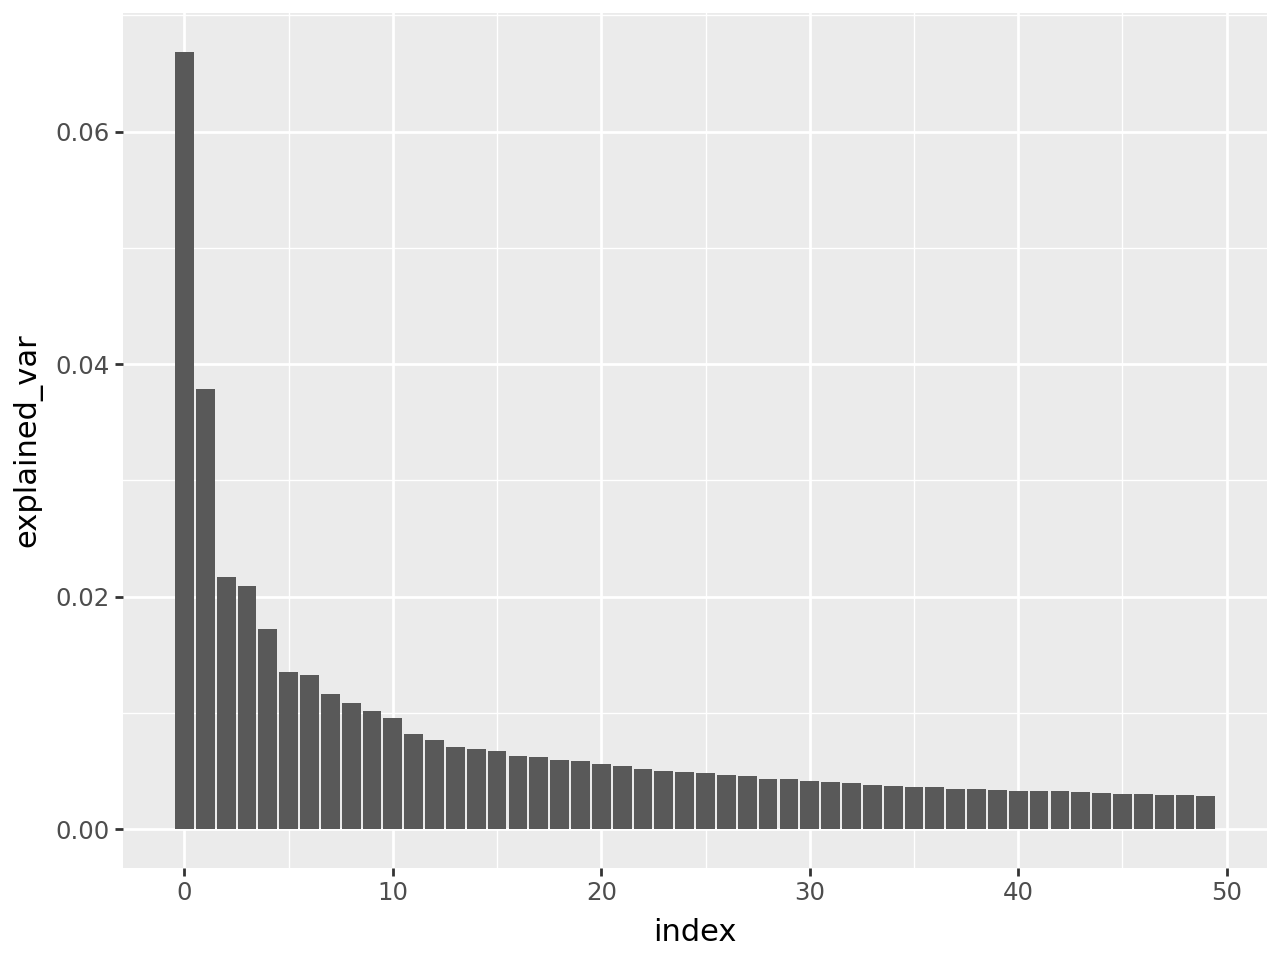

In [6]:
# Output explained variance and quickly visualize
explained_var = pd.DataFrame(pca.explained_variance_ratio_, columns=["explained_var"]).reset_index()

(
    gg.ggplot(explained_var, gg.aes(x="index", y="explained_var"))
    + gg.geom_bar(stat="identity")
)

In [7]:
# Transform models into pca space
dependency_df_transformed = pd.DataFrame(
    pca.transform(dependency_df.drop(columns=["ModelID"]))
)

# Recode column space and add back model IDs
dependency_df_transformed.columns = [f"PCA_{x}" for x in range(0, dependency_df_transformed.shape[1])]
dependency_df_transformed = pd.concat([dependency_df.loc[:, "ModelID"], dependency_df_transformed], axis="columns")

dependency_df_transformed.to_parquet(pca_output_file, index=False)

print(dependency_df_transformed.shape)
dependency_df_transformed.head(3)

(1150, 51)


,ModelID,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,ACH-000001,3.030991,-3.187073,4.503159,2.209107,0.894475,-0.374727,-1.749180,1.088668,1.707850,...,-0.158078,-0.354707,-0.989805,-1.120286,-0.173704,0.406275,-1.622988,-1.986611,2.339763,-0.449185
1,ACH-000004,-1.635936,-2.454653,-3.034755,-1.289442,2.053148,-0.584145,-2.175365,0.115432,0.407777,...,-0.907590,-0.705829,0.262288,0.315329,-0.738839,0.070092,0.338163,1.425833,-0.068876,1.090082
2,ACH-000005,0.483491,-2.110268,-2.506860,-2.267882,4.127780,-1.334216,-0.298557,0.973050,-0.679720,...,0.048817,-0.249422,0.120275,-0.141367,-0.660561,0.311301,-0.416015,1.381675,-0.460517,0.334598


In [8]:
# Obtain weights, which can be used in GSEA
pca_weights = pd.DataFrame(pca.components_, columns=dependency_df.drop(columns=["ModelID"]).columns.tolist()).transpose()
pca_weights.columns = [f"PCA_{x}" for x in range(0, pca_weights.shape[1])]

pca_weights = pca_weights.reset_index().rename(columns={"index": "genes"})

pca_weights.to_parquet(output_pca_weights_file, index=False)

print(pca_weights.shape)
pca_weights.head(3)

(2718, 51)


,genes,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,DIMT1,0.011428,-0.015493,0.004931,0.006268,0.000690,-0.012501,-0.000426,-0.033029,0.003204,...,-0.013186,0.009625,-0.001960,-0.000685,0.005748,0.003454,-0.001605,0.010059,0.013389,0.009066
1,AARS2,0.051206,0.005039,-0.035447,-0.035240,0.006858,0.028463,0.001637,0.022682,-0.006514,...,0.002385,-0.013913,-0.002094,0.024836,-0.008573,-0.003920,-0.005171,-0.011489,0.003951,0.011181
2,LUZP1,0.001690,0.003283,-0.003881,0.011491,0.003548,-0.000136,0.006990,0.000006,0.005657,...,0.022043,0.005970,0.004038,0.006176,0.000992,-0.009590,0.018770,0.001370,-0.002946,-0.006094
